## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd

## Загружаем исходные данные

In [2]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [3]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [4]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

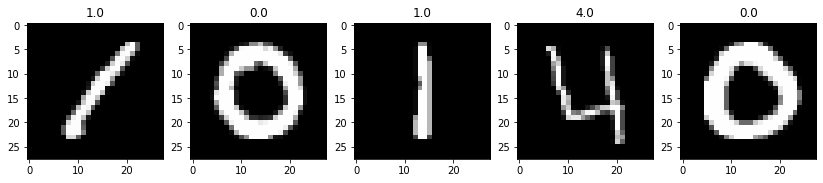

In [5]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

# Basic baselines - KNN & Random Forest

In [6]:
#KNN Baseline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [7]:
train_label = train[:, 0]
train_data = train[:, 1:]
train_data.shape

(42000, 784)

In [8]:
train_x, test_x, train_y, test_y = train_test_split(train_data, train_label, test_size=0.25, random_state=42)

In [9]:
knn = KNeighborsClassifier(n_jobs=-1)
knn.fit(train_x, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

In [10]:
%time preds = knn.predict(test_x)


Wall time: 2min 58s


Wall time: 3min 7s

In [11]:
accuracy_score(test_y, preds)

0.9666666666666667

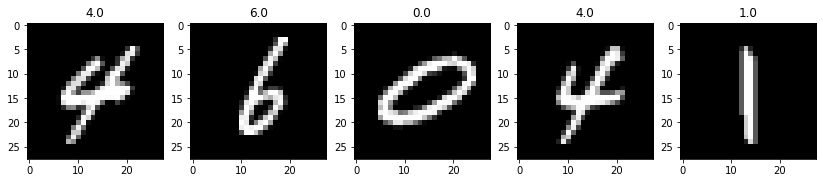

In [12]:
test_img = np.resize(test_x, (test_x.shape[0], 28, 28))
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[100:105], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % preds[99+i]);

## Модель работает. Переобучаем на полной выборке и грузим на Kaggle

In [13]:
knn = KNeighborsClassifier(n_jobs=-1)
knn.fit(train_data, train_label)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

In [14]:
%time preds = knn.predict(test)

Wall time: 9min 51s


## Prediction run time Wall time: 9min 51s

In [15]:
submission = np.ndarray((preds.shape[0], 2), dtype=int)
for i in enumerate(preds):
    submission[i[0]] = [i[0]+1, i[1]]
    
sub_df = pd.DataFrame(data=submission)
sub_df.columns = ['ImageId','Label']
sub_df.to_csv('submission.csv', index=False)

# Kaggle Score - 0.968

In [16]:
# Random forest Baseline
from sklearn.ensemble import RandomForestClassifier

In [17]:
rfc = RandomForestClassifier()
%time rfc.fit(train_x, train_y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Wall time: 2.2 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [18]:
preds = rfc.predict(test_x)

# Random Forest train time - 2.12s, does not depends on prediction size. Much faster, than KNN, but slightly worse

In [19]:
accuracy_score(test_y, preds)

0.9387619047619048

# Lets use PCA to make KNN faster

In [20]:
from sklearn.decomposition import PCA

In [21]:
# No need to scale data - they all have same scale
train_x, test_x, train_y, test_y = train_test_split(train_data, train_label, test_size=0.25, random_state=42)

In [22]:
pca = PCA(n_components=20)
pca.fit(train_x)

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [23]:
pricipal_train = pca.transform(train_x)

In [24]:
knn = KNeighborsClassifier(n_jobs=-1)
knn.fit(pricipal_train, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

In [25]:
%time preds = knn.predict(pca.transform(test_x))

Wall time: 3.09 s


In [26]:
accuracy_score(preds, test_y)

0.9661904761904762

## Использование 20 компонет PCA незначительно снизило точность, но уменьшило время выполнения в 60 раз. попробуем найти оптимальное значение

In [27]:
run_data = []
for i in range (1,51):
    pca = PCA(n_components=i)
    pca.fit(train_x)
    knn = KNeighborsClassifier(n_jobs=-1)
    knn.fit(pca.transform(train_x), train_y)
    preds = knn.predict(pca.transform(test_x))
    score = accuracy_score(preds, test_y)
    run_data.append([i, score])
    print(i, score)

1 0.2758095238095238
2 0.41733333333333333
3 0.4839047619047619
4 0.6158095238095238
5 0.7317142857142858
6 0.819047619047619
7 0.8678095238095238
8 0.8944761904761904
9 0.9078095238095238
10 0.9237142857142857
11 0.930952380952381
12 0.9413333333333334
13 0.9492380952380952
14 0.9547619047619048
15 0.9545714285714286
16 0.9601904761904761
17 0.9616190476190476
18 0.9634285714285714
19 0.965047619047619
20 0.9662857142857143
21 0.9665714285714285
22 0.969047619047619
23 0.9694285714285714
24 0.9706666666666667
25 0.9712380952380952
26 0.9716190476190476
27 0.9718095238095238
28 0.9712380952380952
29 0.9717142857142858
30 0.9716190476190476
31 0.9725714285714285
32 0.9724761904761905
33 0.9721904761904762
34 0.9729523809523809
35 0.972
36 0.9723809523809523
37 0.9725714285714285
38 0.9728571428571429
39 0.9735238095238096
40 0.9726666666666667
41 0.9720952380952381
42 0.9722857142857143
43 0.9728571428571429
44 0.9726666666666667
45 0.9722857142857143
46 0.9732380952380952
47 0.97419047

In [28]:
n_data = np.array(run_data)

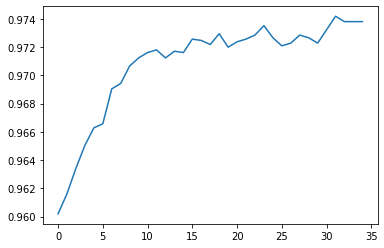

In [29]:
plt.plot(n_data[15:,1])

In [30]:
# Let's use 27 components - it is local max with accuracy 0.972
pca = PCA(n_components=27)
pca.fit(train_x)
knn = KNeighborsClassifier(n_jobs=-1)
knn.fit(pca.transform(train_data), train_label)
#     preds = knn.predict(pca.transform(test_x))
#     score = accuracy_score(preds, test_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

In [31]:
%time preds = knn.predict(pca.transform(test))

Wall time: 16.7 s


# Run time reduced from 10 minutes to 16 seconds (40 times)

In [32]:
submission = np.ndarray((preds.shape[0], 2), dtype=int)
for i in enumerate(preds):
    submission[i[0]] = [i[0]+1, i[1]]
    
sub_df = pd.DataFrame(data=submission)
sub_df.columns = ['ImageId','Label']
sub_df.to_csv('submission_pca.csv', index=False)

# Kaggle score increased to 0.972

In [33]:
# Let's use 27 components - it is local max with accuracy 0.972
pca = PCA(n_components=47)
pca.fit(train_x)
knn = KNeighborsClassifier(n_jobs=-1)
knn.fit(pca.transform(train_data), train_label)
#     preds = knn.predict(pca.transform(test_x))
#     score = accuracy_score(preds, test_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

In [34]:
%time preds = knn.predict(pca.transform(test))

Wall time: 36.9 s


In [35]:
submission = np.ndarray((preds.shape[0], 2), dtype=int)
for i in enumerate(preds):
    submission[i[0]] = [i[0]+1, i[1]]
    
sub_df = pd.DataFrame(data=submission)
sub_df.columns = ['ImageId','Label']
sub_df.to_csv('submission_pca_2.csv', index=False)

In [ ]:
# Best result with score 0.97314